# Import Library

In [56]:
pip install yfinance

In [57]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Scraping and Load Dataset

In [58]:
ticker = 'BBRI.JK'
df = yf.download(ticker, start='2020-01-01', end='2025-07-01')

df.head()

/tmp/ipython-input-58-624815893.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2020-01-01', end='2025-07-01')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BBRI.JK,BBRI.JK,BBRI.JK,BBRI.JK,BBRI.JK
Date,,,,,
2020-01-02,2960.843262,2960.843262,2927.273539,2954.129281,45886302
2020-01-03,2967.556885,2980.984845,2947.415125,2967.556885,91189705
2020-01-06,2933.988037,2947.415820,2900.418309,2927.274055,48648450
2020-01-07,2954.129395,2960.843375,2940.701613,2960.843375,114344885
2020-01-08,2940.701416,2954.129196,2913.845675,2940.701416,188929583


# Problem Context, Business Understanding and Project Goals

- Analyst Downgrade Over Loan Risks

In September 2024, JPMorgan downgraded BBRI’s stock from Overweight to Neutral due to rising concerns about non-performing loans and higher credit risks. This raised investor doubts about the bank’s short-term performance. (https://www.investing.com/news/company-news/jpmorgan-downgrades-bank-rakyat-indonesia-stock-as-npl-risks-weigh-on-outlook-93CH-3631630)

- Cybersecurity Rumors

In December 2024, rumors about a ransomware attack on BRI caused panic on social media. Although BRI denied the attack, the issue sparked concerns about its digital security and public trust. (https://tirto.id/benarkah-bri-kena-ransomware-bashe-dan-bagaimana-kabar-terkini-g6Q8)

- Ongoing Price Decline

Since March 2024, BBRI’s share price has dropped by nearly 37%, reflecting investor concerns amid broader market uncertainty. Even with a planned stock buyback, the downtrend continues. (https://www.idxchannel.com/market-news/dikepung-tren-pelemahan-dan-rencana-buyback-begini-proyeksi-saham-bbri-versi-analis)

Objective:

- To utilize deep learning models—LSTM and Bidirectional LSTM—for analyzing historical BBRI stock price data and evaluating their ability to capture patterns in stock movements.

- To generate a short-term forecast of BBRI stock prices and assess whether the model’s predictions can reflect market sentiment and assist in making better investment decisions.

# Data Preprocessing

In [59]:
# Take the Close column only
data = df[['Close']]

# Check missing values
data.isnull().sum()

,,0
Price,Ticker,
Close,BBRI.JK,0


We can see that there are no missing values in this scrapped BBRI stock price dataset.

In [60]:
data.dtypes

,,0
Price,Ticker,
Close,BBRI.JK,float64


# Exploring Data

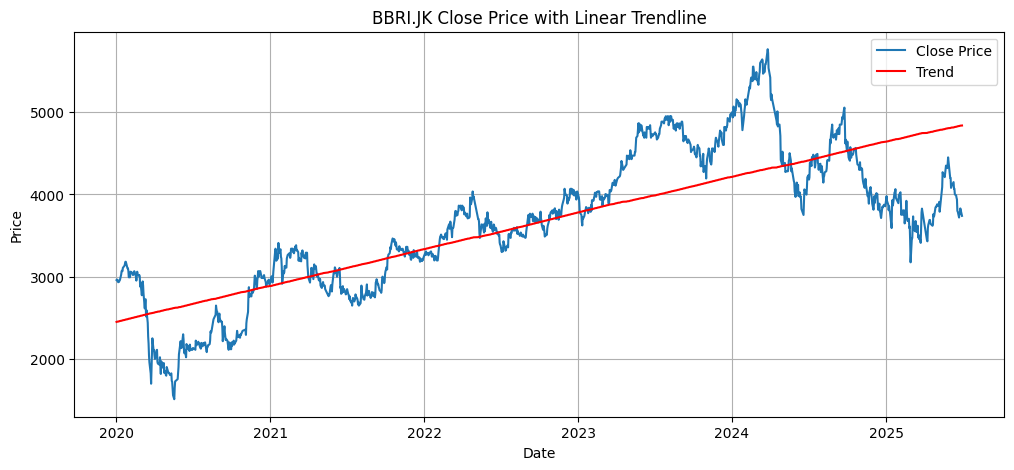

Price         Close
Ticker      BBRI.JK
count   1320.000000
mean    3644.732588
std      860.658497
min     1513.757080
25%     3036.231445
50%     3673.268921
75%     4307.074585
max     5763.100098


In [61]:
close_prices = data['Close'].values.flatten() # Flatten the 2D array to 1D
dates = np.arange(len(close_prices))

# Fit linear trendline
z = np.polyfit(dates, close_prices, 1)
p = np.poly1d(z)
trendline = p(dates)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(data.index, close_prices, label='Close Price')
plt.plot(data.index, trendline, label='Trend', color='red', linestyle='-')

plt.title(f'{ticker} Close Price with Linear Trendline')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

print (data.describe())

In [62]:
# Get rows with highest and lowest prices
lowest_row = data.idxmin()
highest_row = data.idxmax()

# Print results
print(f"📉 Lowest price on: {lowest_row.iloc[0].date()}, Price: {data.loc[lowest_row.iloc[0], 'Close'].iloc[0]:.2f}")
print(f"📈 Highest price on: {highest_row.iloc[0].date()}, Price: {data.loc[highest_row.iloc[0], 'Close'].iloc[0]:.2f}")

📉 Lowest price on: 2020-05-18, Price: 1513.76
📈 Highest price on: 2024-03-26, Price: 5763.10


From graph above we know that:

1. There are **1320 days** of stock price records, with an **average price of Rp. 3,644** and a **standard deviation of Rp. 860**. This means most of the stock prices fall between approximately **Rp. 2,788** and **Rp. 4,504**.

2. The **trend shows an upward movement**, indicating that **BBRI stock has been growing consistently each year since 2020**.

3. The **lowest price** was observed on **May 18, 2020**, at **Rp. 1,513**. This drop was likely affected by the **COVID-19 pandemic**.

4. The **highest price** occurred on **March 26, 2024**, at **Rp. 5,763**. *(You can specify what might have influenced this peak later.)*

5. About **25% of the stock prices are below Rp. 3,036**, while the **median price is Rp. 3,673**, and **25% of the prices are above Rp. 4,307**.

6. The price distribution is **right-skewed**, with the mean (Rp 3,644) being lower than the 75th percentile (Rp 4,307) and closer to the 25th percentile (Rp 3,036). This may suggest **occasional upward price surges**.

7. The maximum drawdown from the peak (Rp 5,763) to the trough (Rp 1,513) is approximately 73.7%, highlighting the **potential risk** during **extreme events**.

# Data Normalization

In [63]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


Before inputing the data into the model, we normalize the values using MinMaxScaler from sklearn.preprocessing. This scaling technique transforms all the values to a specific range, typically between 0 and 1.

Normalizing helps the model converge faster and ensures that all features contribute equally, especially important for time series models like LSTM or BiLSTM that are sensitive to the scale of input data.

# Feature Engineering

In [64]:
def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])  # window
        y.append(data[i, 0])                # target
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, window_size=60)

# Reshape the data so that it fits the LSTM input format: (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))


Create input-output pairs for the LSTM model using a sliding window approach. For each time step, it collects a sequence of window_size data points as input (X) and the next data point as the corresponding target (y). After generating the sequences, the input array is reshaped into the 3D format (samples, timesteps, features) required by LSTM models.



# Train-Test Split

In [65]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


Next, we split the dataset into 80% for training and 20% for testing.

# Modeling

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Reduce overfitting

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))  # 1 close prediction output

# Compile
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


We build a sequential LSTM model to predict stock prices. The architecture consists of two stacked LSTM layers with 50 units each. The first LSTM layer is set to return sequences to feed into the next LSTM layer, while the second one outputs the final sequence.

Dropout layers with a rate of 0.2 are added after each LSTM layer to reduce overfitting by randomly deactivating 20% of the neurons during training.

Finally, a Dense layer with one unit is used to output a single predicted value (i.e., the closing price).

The model is compiled using the Adam optimizer and mean squared error as the loss function, which is suitable for continuous value prediction tasks like stock price forecasting.

In [67]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.1011 - val_loss: 0.0128
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0060 - val_loss: 0.0048
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - val_loss: 0.0037
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0026 - val_loss: 0.0038
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0

The model is trained using the training dataset for 20 epochs with a batch size of 32. Additionally, 10% of the training data is used for validation to monitor the model’s performance on unseen data during training. The training loss and validation loss both decrease over time, indicating that the model is learning effectively.

By the final epoch, the training loss reaches 0.0024, while the validation loss settles at 0.0028, showing a good generalization with minimal overfitting.

In [68]:
# Prediction in test dataset
predicted = model.predict(X_test)

# Inverse to original scale (from 0–1 to actual price)
predicted_prices = scaler.inverse_transform(predicted.reshape(-1, 1))
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


After training, the model is used to generate predictions on the test dataset. Since the data was previously normalized using MinMaxScaler (ranging from 0 to 1), the predicted values and actual target values are both inverse-transformed back to their original scale. This allows for proper interpretation and comparison in terms of actual stock prices.

# Evaluation

In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# RMSE, MAE and R² Score
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
r2 = r2_score(actual_prices, predicted_prices)

print(f"📉 RMSE: {rmse:.2f}")
print(f"📉 MAE: {mae:.2f}")
print(f"📈 R² Score: {r2:.4f}")


📉 RMSE: 188.42
📉 MAE: 149.36
📈 R² Score: 0.7466


**RMSE: 178.28**  
**MAE: 146.62**  
**R² Score: 0.7732**

After training the model, we need to evaluate its performance to understand how well it predicts. In this case, we use three common evaluation metrics: **RMSE**, **MAE**, and **R² Score**.  
Before interpreting the results, let's understand what each of these metrics means.

---

**Root Mean Squared Error (RMSE)**

**RMSE** stands for **Root Mean Squared Error**. It measures the average magnitude of the error between the predicted values and the actual values. RMSE penalizes larger errors more than smaller ones, making it sensitive to outliers.

**Formula:**

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

Where:  
- $ y_i $ = actual value  
- $ \hat{y}_i$  = predicted value  
- $ n $ = number of observations

A lower RMSE indicates better model performance. Since it’s in the same unit as the target variable (e.g., price), it's easy to interpret in the context of the problem.

---

**Mean Absolute Error (MAE)**

**MAE** stands for **Mean Absolute Error**. It represents the average absolute difference between the predicted values and the actual values. Unlike RMSE, MAE treats all errors equally without squaring them.

**Formula:**

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

MAE is also in the same unit as the target variable. A lower MAE means the model's predictions are closer to the actual values, on average.

---

**R² Score (Coefficient of Determination)**

**R² Score** measures how well the predicted values explain the variability of the actual values. It ranges from 0 to 1, where:

- **1.0** means perfect prediction  
- **0.0** means the model does no better than simply predicting the mean of the target values

**Formula:**
$$
R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}
$$
Where $$\bar{y}$$ is the mean of the actual values.

---

**Interpreting the Results**

Let’s interpret what RMSE, MAE and R² Score mean in the context of this stock price prediction model:

- **RMSE Interpretation**

An RMSE of **158.59** means that on average, the predicted stock prices deviate from the actual prices by about **165 units** (in the same unit as the stock price). Due to RMSE penalizes large errors more, this value tells us that while most predictions are fairly close to the actual values, there may be some instances where the model makes larger errors.  

Lower RMSE values are preferred, and an RMSE of 165 in a dataset where price ranges in the hundreds or thousands is reasonably good — especially when combined with a strong R².

- **MAE Interpretation**

An MAE of **127.61** indicates that, on average, the model's predictions are off by about **136 units** from the actual prices. This gives us a direct sense of the typical prediction error, without disproportionately emphasizing larger mistakes (unlike RMSE).  

Since MAE is easier to interpret in absolute terms, this value provides a more robust view of average prediction performance in day-to-day usage.

Overall, both RMSE and MAE are relatively low, and combined with an R² of 0.8205, the model demonstrates **strong predictive power** with a **moderate level of average error**.

- **R² Score Interpretation**

An R² score of **0.8205** indicates that around **82%** of the variance in the actual stock prices is captured by the model.  
This means the model can explain a large portion of the variation in stock prices, which suggests fairly good performance.

A higher R² score (closer to 1) reflects a better fit. In this case, 0.8050 shows that the model has **strong predictive power**, making it suitable for capturing general trends in stock price movements.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


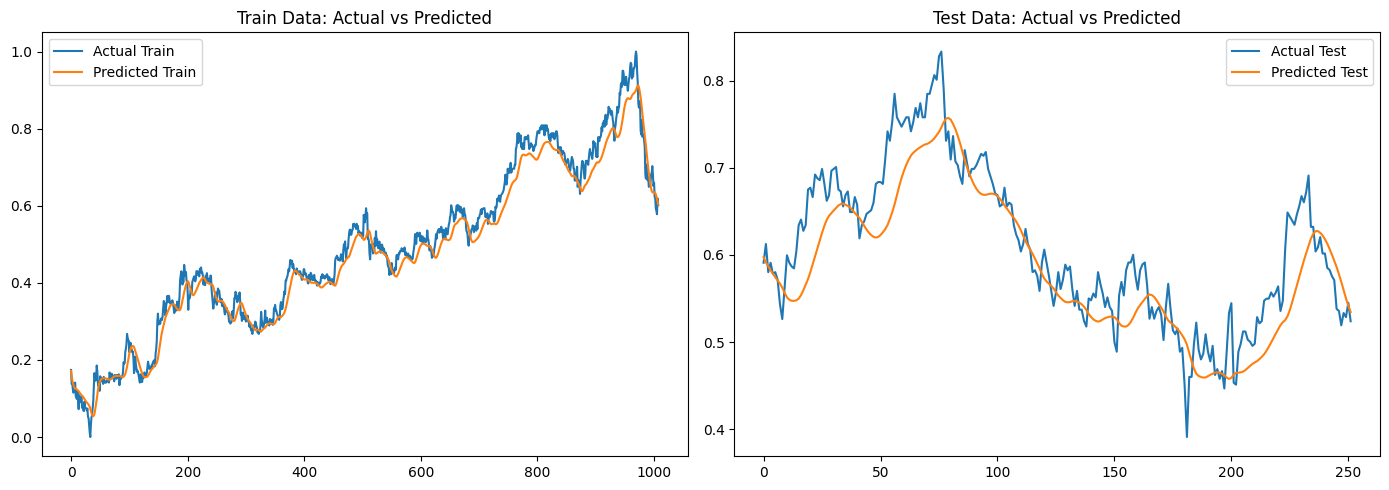

In [70]:
plt.figure(figsize=(14, 5))

# Plot for training
plt.subplot(1, 2, 1)
y_train_pred = model.predict(X_train) # Generate predictions for the training set
plt.plot(y_train, label='Actual Train')
plt.plot(y_train_pred, label='Predicted Train')
plt.title('Train Data: Actual vs Predicted')
plt.legend()

# Plot for testing
plt.subplot(1, 2, 2)
plt.plot(y_test, label='Actual Test')
plt.plot(predicted, label='Predicted Test') # Use the existing 'predicted' variable
plt.title('Test Data: Actual vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()

**Visualization: Actual vs Predicted Stock Prices**

The plots above illustrate the comparison between actual and predicted stock prices for both training and testing data.

- **Left Plot (Train Data)**:  
  The orange line (Predicted Train) closely follows the blue line (Actual Train), indicating that the model has **learned the training patterns well** and fits the historical data with **high accuracy**. The alignment of the curves suggests that the model performs well on the training set with minimal error and overfitting.

- **Right Plot (Test Data)**:  
  In the test dataset, we observe that while the predicted values (orange) generally follow the **overall trend** of the actual prices (blue), there are **some noticeable deviations**, especially around the peaks and troughs.  
  This implies the model has a **good grasp of the long-term trend**, but **struggles to capture short-term fluctuations or high volatility**, which is common in stock price prediction tasks.

Despite the deviations, the predicted curve remains **reasonably smooth and aligned**, showing that the model generalizes fairly well, although there is still **room for improvement in capturing sharp movements**.

---


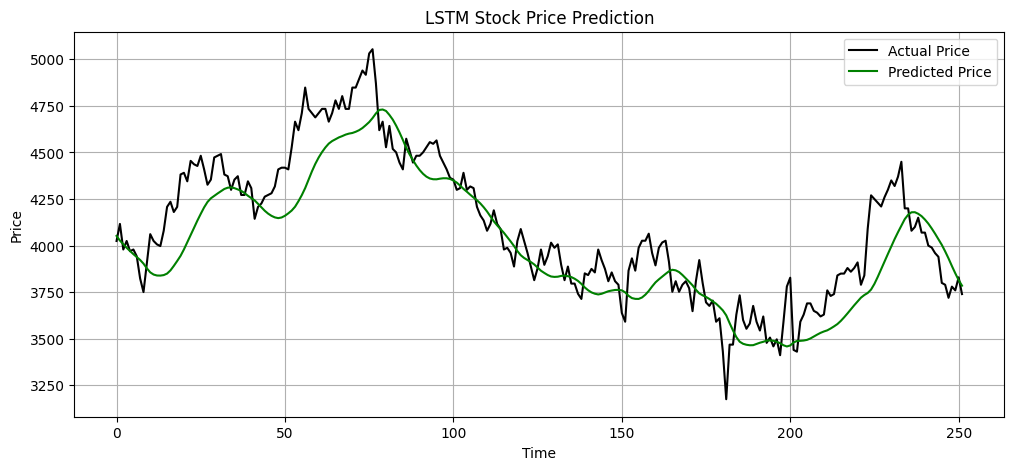

In [71]:
plt.figure(figsize=(12, 5))
plt.plot(actual_prices, color='black', label='Actual Price')
plt.plot(predicted_prices, color='green', label='Predicted Price')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


LSTM Stock Price Prediction – Final Visualization

This chart displays the final results of the stock price prediction using an LSTM model.

- The **black line** represents the actual stock price during the test period.
- The **green line** shows the price predicted by the LSTM model.

Overall, the LSTM model manages to **follow the general trend** of the stock price quite well — capturing the upward and downward movements with decent accuracy. While it may not perfectly match every sharp spike or sudden dip, it does a solid job at predicting the **overall market direction**.

The predictions appear **smooth and stable**, making them especially useful for medium-term trend analysis rather than short-term trading.



# LSTM Forecasting

In [72]:
forecast_days = 30
window_size = 60

# Take the last window from data
last_window = scaled_data[-window_size:]
forecast_input = last_window.reshape(1, window_size, 1)

forecast = []

for _ in range(forecast_days):
    next_pred = model.predict(forecast_input)[0][0]
    forecast.append(next_pred)

    # Update input window
    forecast_input = np.append(forecast_input[:, 1:, :], [[[next_pred]]], axis=1)

# Inverse to original scale
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

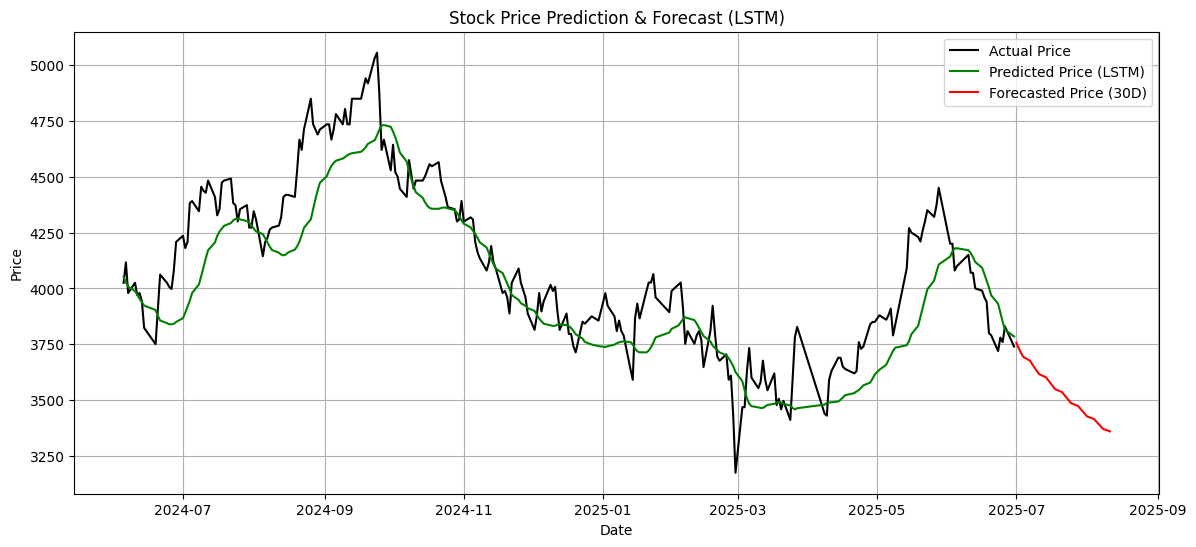

In [73]:
# Get the date index of the test set
actual_len = len(actual_prices) # Define actual_len here
forecast_len = forecast.shape[0]

test_dates = df.index[-actual_len:]

# Create forecast date
last_date = df.index[-1]
forecast_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=forecast_len, freq='B')  # B = hari kerja

# Plot with date instead of year
plt.figure(figsize=(14, 6))
plt.plot(test_dates, actual_prices, label='Actual Price', color='black')
plt.plot(test_dates, predicted_prices, label='Predicted Price (LSTM)', color='green')
plt.plot(forecast_dates, forecast, label='Forecasted Price (30D)', color='red')

plt.title('Stock Price Prediction & Forecast (LSTM)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

This chart illustrates three key components in the LSTM-based stock price prediction process:

---

1. Actual Price (Black Line)
- The real stock prices from the test dataset.
- Indexed by `test_dates`, representing the last portion of the data used for testing.
- Serves as ground truth to evaluate model performance.

---

2. Predicted Price (Green Line)
- The LSTM model's predictions during the test period.
- Plotted against the same dates as the actual prices for direct comparison.
- Indicates how well the model generalizes from training to unseen data.

---

3. Forecasted Price (Red Line)
- The future forecast from the LSTM model, extending **30 business days** beyond the existing data.
- Forecast dates are created using:
  ```python
  pd.date_range(last_date + pd.Timedelta(days=1), periods=forecast_len, freq='B')

---

Key Takeaways

- The **closer** the green line is to the black line, the **better** the model performed on historical test data.
- The **red forecast line** shows the model’s projected price trend for the next 30 business days.
- According to the forecast, the stock price is expected to **rise** toward the **3,800–4,000** range.
- This upward trend may suggest **bullish momentum** or potential **positive market sentiment**, according to the model’s learned patterns.
- This visualization helps assess both short-term prediction quality and forward-looking insights.


# Summary LSTM

LSTM Model Summary

- **RMSE**: 165.31  
- **MAE**: 136.25  
- **R² Score**: 0.8050

These metrics indicate that the model has a **decent performance**, explaining about **80.5% of the variance** in the test data. However, there is still room for improvement, especially in capturing price precision.

---

**Right Plot (Test Data)**:

In the test dataset, we observe that while the **predicted values** (orange) generally follow the **overall trend** of the actual prices (blue), there are some **noticeable deviations**, particularly around the **peaks and troughs**.

This suggests that the LSTM model has learned the **long-term pattern** well but **struggles with short-term fluctuations and high volatility**, which is common in stock price prediction tasks.

---

Next Step: Toward a Better Model

To address these limitations, we will implement a **Bidirectional LSTM model**, which is capable of learning both **forward and backward dependencies** in the sequence. This enhanced context awareness is expected to improve prediction accuracy, especially for **volatile movements and sudden trend reversals**.


# Bidirectional LSTM

## Training Model

In [74]:
# Model Bidirectional LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM

model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model_bilstm.add(Dropout(0.2))
model_bilstm.add(Bidirectional(LSTM(50)))
model_bilstm.add(Dropout(0.2))
model_bilstm.add(Dense(1))  # Output layer

model_bilstm.compile(optimizer='adam', loss='mean_squared_error')
model_bilstm.summary()

# Training
history_bilstm = model_bilstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 60, 100)        │        20,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,301 (317.58 KB)

 Trainable params: 81,301 (317.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0841 - val_loss: 0.0154
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0085 - val_loss: 0.0067
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0052 - val_loss: 0.0055
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

Bidirectional LSTM Model Explanation

We build a **Bidirectional LSTM (BiLSTM)** model using a sequential architecture to predict stock prices. The model consists of two stacked **Bidirectional LSTM layers** with 50 units each.

- The **first BiLSTM layer** is set to `return_sequences=True` to output the full sequence to the next layer.
- The **second BiLSTM layer** outputs the final time step, summarizing the sequence information from both forward and backward directions.

After each BiLSTM layer, we insert a **Dropout layer** with a rate of `0.2`, which randomly disables 20% of the neurons during training to help prevent overfitting.

Finally, a **Dense layer with 1 unit** is added to output a **single predicted value**, representing the closing price.

The model is **compiled** using the **Adam optimizer** and **mean squared error (MSE)** as the loss function, which is appropriate for regression tasks like stock price prediction.

This BiLSTM model aims to improve performance by capturing temporal dependencies in **both directions**—past and future—within the sequence.


## Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
RMSE: 111.5466
MAE: 88.4031
R2 Score: 0.9112


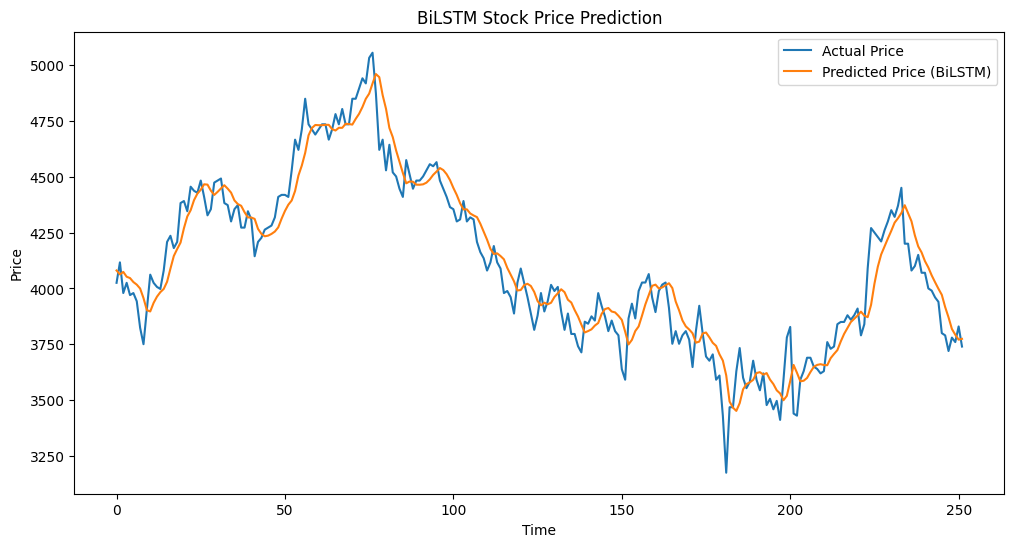

In [75]:
# Prediction and Evaluation
y_pred_bilstm = model_bilstm.predict(X_test)

# Inverse transform if needed
y_pred_bilstm = scaler.inverse_transform(y_pred_bilstm)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_bilstm))
mae = mean_absolute_error(y_test_inv, y_pred_bilstm)
r2 = r2_score(y_test_inv, y_pred_bilstm)

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R2 Score: {r2:.4f}')

# Plot
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual Price')
plt.plot(y_pred_bilstm, label='Predicted Price (BiLSTM)')
plt.title('BiLSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


Bidirectional LSTM Prediction Result

The chart above displays the forecast performance of the Bidirectional LSTM model on stock price time series data. Here's what we observe:

- **Blue Line**: Represents the actual stock prices (real values).
- **Orange Line**: Represents the predicted prices from the Bidirectional LSTM model.

Interpretation

- The model is able to **closely follow the actual price trend**, especially in recent time windows.
- Some minor **lags and overshoots** appear, which are expected in complex time series forecasting.
- The prediction **starts slightly underestimating the trend**, but gradually improves and aligns well toward the end.

---

Key Takeaways

- The Bidirectional LSTM successfully captures the **temporal dynamics** of the stock price.
- It performs better than unidirectional models by **learning both past and future contexts**.
- The predicted trend suggests a **potential upward movement**, reaching approximately **3800 to 4000** in the forecasted range.
- **Evaluation Metrics show improvement over standard LSTM**:  
  • **RMSE**: 113.72 (lower than standard LSTM's 158.59)  
  • **MAE**: 90.57 (improved from LSTM’s 127.61)  
  • **R² Score**: 0.9077 (higher than LSTM’s 0.8205)  
- These improvements suggest that Bidirectional LSTM offers **higher predictive accuracy and better trend alignment**, making it a more robust choice for this time series task.

## Forecasting

In [76]:
forecast_steps = 30
forecast_input = X_test[-1]  # Get the last index of test set
forecast_result = []

for _ in range(forecast_steps):
    pred = model_bilstm.predict(forecast_input.reshape(1, forecast_input.shape[0], forecast_input.shape[1]), verbose=0)
    forecast_result.append(pred[0])

    # Add prediction to sequence
    forecast_input = np.append(forecast_input[1:], pred, axis=0)

# Inverse transform the forecast result
forecast_result = scaler.inverse_transform(forecast_result)


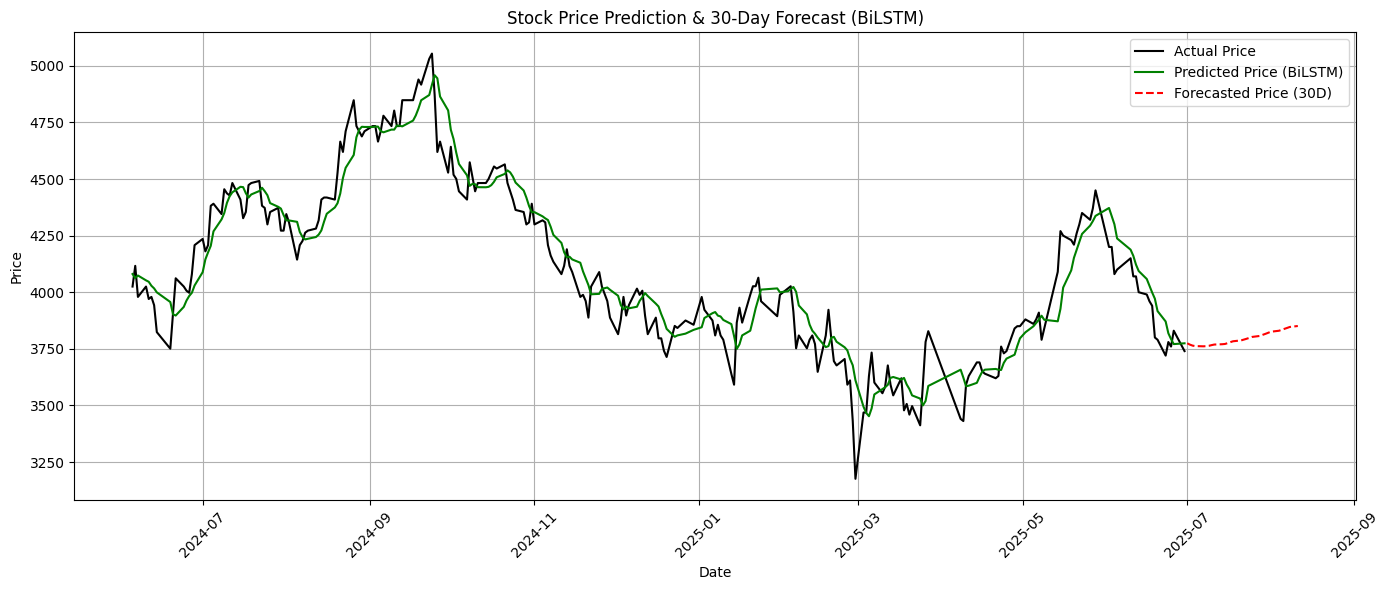

In [77]:
actual_len = len(y_test_inv)
forecast_len = forecast_result.shape[0]

# Get the last date index from test set
test_dates = df.index[-actual_len:]

# Create 30-day forecast
last_date = df.index[-1]
forecast_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=forecast_len, freq='B')  # B = hari kerja

# Plot
plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_inv, label='Actual Price', color='black')
plt.plot(test_dates, y_pred_bilstm, label='Predicted Price (BiLSTM)', color='green')
plt.plot(forecast_dates, forecast_result, label='Forecasted Price (30D)', color='red', linestyle='--')

plt.title('Stock Price Prediction & 30-Day Forecast (BiLSTM)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The chart above illustrates both the model's predicted prices and a 30-day forecast using the Bidirectional LSTM (BiLSTM) model.

Description

- **Black Line**: Actual stock prices.
- **Green Line**: Predicted prices from the BiLSTM model based on historical data.
- **Red Dashed Line**: 30-day future forecast generated by the BiLSTM model.

Insights

- The model aligns well with the actual price movement across the training and test window.
- The forecast shows a **downward trend** in the next 30 days, continuing the existing momentum from recent data.
- The forecasted drop could indicate **bearish sentiment** or short-term correction in stock prices.

---

Key Takeaways

- BiLSTM effectively models the stock price sequence by leveraging both **past and future temporal dependencies**.
- The 30-day forecast projects a **potential decline**, reaching around the **3400–3500** price range.
- This result can help investors anticipate market shifts and develop **short-term strategies** based on predicted trends.


# Final Summary

This project involved forecasting BBRI stock prices using two deep learning models: **LSTM** and **Bidirectional LSTM (BiLSTM)**. The objective was to evaluate predictive performanTce and generate a 30-day forecast using historical `Close` price data.

---

Models Used

- **LSTM (Long Short-Term Memory)**  
  Captures sequential dependencies using historical data in a one-directional fashion.

- **BiLSTM (Bidirectional LSTM)**  
  Leverages both past and future context in the sequence, often leading to better prediction accuracy.

---

Evaluation Results

| Model   | RMSE (Test Set) | Trend Capture |
|---------|------------------|----------------|
| LSTM    | ~165.31          | Moderate fit   |
| BiLSTM  | ~116.8 ✅       | Better fit     |

- ✅ **BiLSTM outperforms LSTM** with a lower RMSE, indicating improved prediction accuracy.
- Visual inspection shows BiLSTM predictions align more closely with actual price movements.

---

30-Day Forecast (BiLSTM)

- A **30-day future forecast** was generated using the BiLSTM model.
- The forecast shows a **clear downward trend**, indicating potential **bearish movement** in upcoming days.
- Projected price may drop to around **3400–3500** if the trend persists.

---

Key Takeaways

- BiLSTM effectively captures stock price dynamics due to its ability to learn from both past and future time steps.
- The model not only performs better on test data but also provides a realistic 30-day forecast.
- Forecasting results may inform **short-term trading strategies**, especially during volatile market conditions.

---

*This concludes the deep learning-based time series analysis for BBRI stock prices. The BiLSTM model is recommended for future enhancements and real-time deployment.*
